# Credit Fraud Prediction

# Table of Contents
1. [The project](#toc1)
2. [The Dataset](#toc2)
3. [Exploratory Data Analysis](#toc3)  
3.1 [V_features](#toc31)  
3.2 [Amount](#toc32)  
3.3 [Time](#toc33)
4. [Correlation Search](#toc4)
5. [Model Building](#toc5)  
6. [Deal with imbalance](#toc6)  
6.1 [Auto Weight](#toc61)  
6.2 [Manual Weight](#toc62)  
7. [Predict Test set](#toc7) 

<a id=toc1></a>
# 1. The project 

In this project, we will look into a fast technique of the library scikit-learn to create a prediction quickly to deal with imbalanced classification problem  : <strong>class_weight</strong> 

In [377]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, cross_val_predict,cross_val_score
import warnings
warnings.filterwarnings('ignore')

#To visualize graphs on jupyter notebook
%matplotlib inline
#PATH of the project folder
PROJECT_ROOT_DIR=os.getcwd()
#Create Images folder
IMAGES_PATH=os.path.join(PROJECT_ROOT_DIR,"Images")
if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)
    
#Function to save figures in the images folder
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(IMAGES_PATH, fig_id + ".png")
    print("Figure {} saved".format(fig_id))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

<a id=toc2></a>
# 2. The Dataset

We will study the <a href=https://www.kaggle.com/mlg-ulb/creditcardfraud> Credit Fraud dataset </a>

The columns of the dataset are:

- **Time** -- Seconds elapsed between each transaction.
- **Amount** -- Transaction Amount
- **V1-V28** -- Unknown features.
- **Class** 
    - 1 if fraud 
    - 0 o.w.  
    --> <strong>We want to predict this column</strong>

In [378]:
df=pd.read_csv('creditcard.csv')
df=df.sample(frac=1).reset_index(drop=True)

In [379]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,143907.0,-1.402087,2.031091,-2.563411,-1.389507,0.776342,-0.474528,0.335976,1.169873,-0.431509,...,0.261985,0.707906,-0.170622,-0.307449,-0.055331,0.132102,0.237436,0.195619,2.33,0
1,64870.0,-0.526362,-0.212365,1.030211,-1.497385,0.051677,-0.338559,0.207958,0.025778,-1.664220,...,0.354930,0.677422,-0.187920,-0.490256,0.197756,-0.129561,0.051802,0.099241,69.90,0
2,122491.0,-2.508216,1.413163,-2.434867,-0.418528,0.054486,-1.053644,0.472839,-0.261357,-1.005477,...,0.428047,1.828197,-0.007324,0.797898,0.292298,0.543054,-0.931342,0.495203,20.00,0
3,85375.0,-0.467086,0.964053,1.659557,-0.095197,-0.170291,-0.701929,0.568485,0.101143,-0.578858,...,-0.170244,-0.493255,-0.003450,0.500040,-0.271954,0.043118,0.258094,0.111495,2.58,0
4,161035.0,-0.629607,-0.271002,1.714426,-3.007261,-0.776961,-0.683528,-0.163676,-0.026845,-1.958415,...,-0.204404,-0.106879,-0.379466,-0.141483,0.673419,-0.111084,0.275990,0.110557,10.40,0


### First look at the label

Figure Freaud class histogram saved


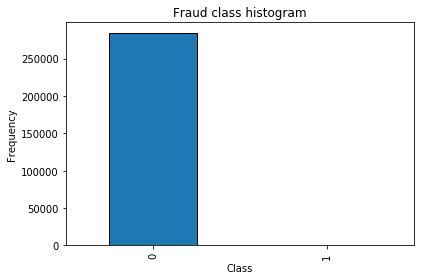

In [380]:
freq_classes = pd.value_counts(df['Class'])
freq_classes.plot(kind = 'bar', edgecolor='black')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
save_fig('Freaud class histogram')
plt.show()

In [381]:
count_classes

0    284315
1       492
Name: Class, dtype: int64

### We can see that this dataset is highly imbalanced

<a id=toc3></a>
# 3. Exploratory Data Analysis

In [382]:
Missing_Tab=pd.DataFrame(df.isnull().sum().sort_values(ascending=False),columns=['Missing values'])

In [383]:
Missing_Tab['% Missing']=round(Missing_Tab/df.shape[0]*100,4)
Missing_Tab

,Missing values,% Missing
Class,0,0
V14,0,0
V1,0,0
V2,0,0
V3,0,0
V4,0,0
V5,0,0
V6,0,0
V7,0,0
V8,0,0


## Not missing values ! Good news !

<a id=toc31></a>
## &emsp; 3.1 V_features

## First we will look into the Unknown features "V#" through visualization

In [384]:
#Create a list of all V_features
V_features=['V'+str(i) for i in range(1,29)]

In [385]:
def Distribution_plot(df,figsizeh,figsizev,subR,subC,Columns,title=None):
    plt.figure(figsize=(figsizeh,figsizev))
    for i, feature in enumerate(Columns):
 
    # create a new subplot for each source
        plt.subplot(subR, subC, i + 1)
    # plot repaid loans
        sns.kdeplot(df.loc[df['Class'] == 0, feature], label = 'Not fraud')
    # plot loans that were not repaid
        sns.kdeplot(df.loc[df['Class'] == 1, feature], label = 'Fraud')
    
    # Label the plots
        plt.title('Distribution of %s by Target Value' % feature)
        plt.xlabel('%s' % feature); plt.ylabel('Density');
        plt.legend(loc="upper right")
    plt.tight_layout()
    if title is not None:
        save_fig(title)
    plt.show()

Figure Kde for each V_features saved


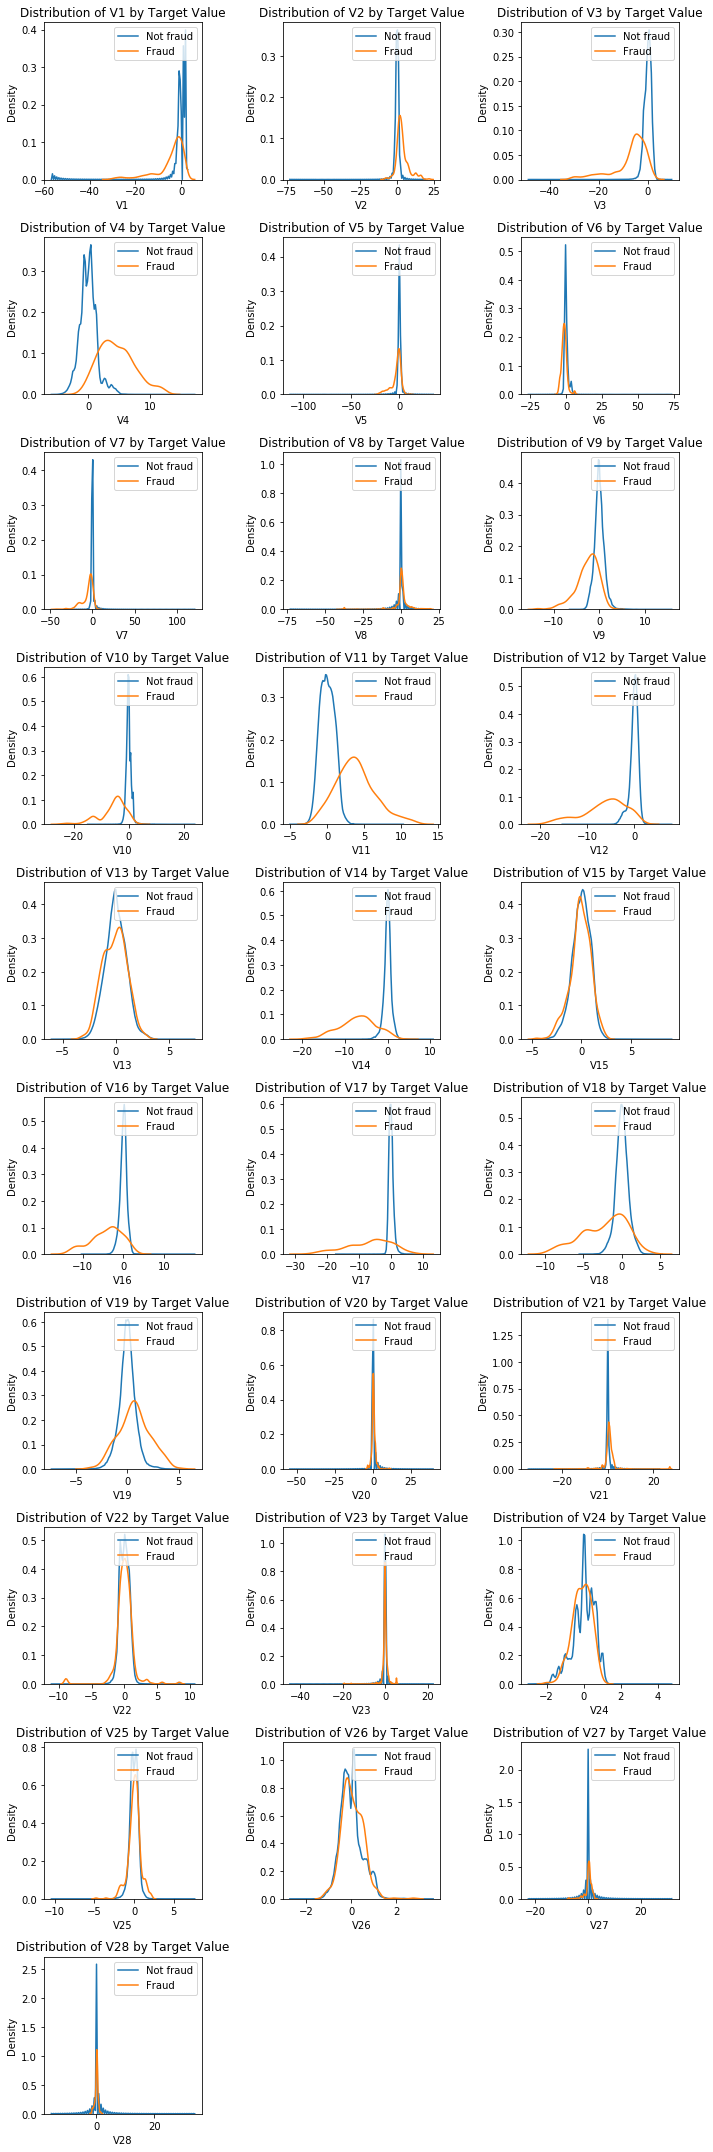

In [386]:
Distribution_plot(df,10,30,10,3,V_features,'Kde for each V_features')

<strong>If we explore the behavior of the distribution for each features depending on the class, we can look for differencies. For most of the V features, we can see that the behavior is independant of the target (exact same pattern). However a few features are very interesting. 
For V2,V4,V11:
- When there isn't fraud the feature is always close to 0
- When there is fraud the value is positive

For V3,V10,V12,V14,V16,V17,V18
- When there isn't fraud the feature is always close to 0
- When there is fraud the value is negative
    
We will select this features with "a strong" correlation with the target

<a id=toc32></a>
## &emsp; 3.2 Amount

Figure Kde for Amount features saved


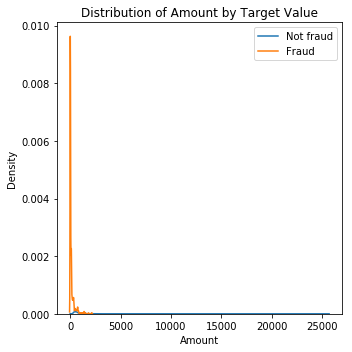

In [387]:
Distribution_plot(df,5,5,1,1,['Amount'],'Kde for Amount features')

Figure Amount feature saved


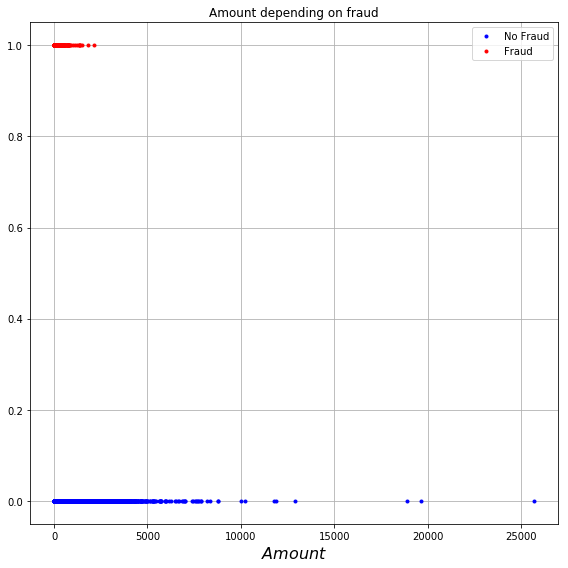

In [388]:
plt.figure(figsize=(8,8))
plt.plot(df[df['Class']==0]["Amount"],df[df['Class']==0]["Class"],'b.',label='No Fraud')
plt.plot(df[df['Class']==1]["Amount"],df[df['Class']==1]["Class"],'r.',label='Fraud')
plt.grid()
plt.xlabel("$Amount$",fontsize=16)
plt.title("Amount depending on fraud")
plt.legend()
save_fig('Amount feature')
plt.show()

We can see that the amount is always small when there is fraud otherwise it could be any amount possible from 0 to 25000+

In [389]:
min_fraud=df[df['Class']==1]['Amount'].min()
max_fraud=df[df['Class']==1]['Amount'].max()
print('Minimun amount fraud : {}'.format(min_fraud))
print('Maximun amount fraud : {}'.format(max_fraud))

Minimun amount fraud : 0.0
Maximun amount fraud : 2125.87


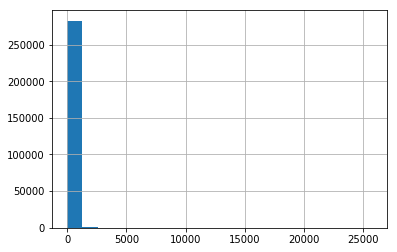

In [390]:
df[df['Class']==0]["Amount"].hist(bins=20)
plt.show()

However most of the no-fraud transaction are also less than 2500, even if the information is interesting, this doesn't seem to help...  
Let's move on !

<a id=toc33></a>
## &emsp; 3.3 Time

Figure Kde for Time features saved


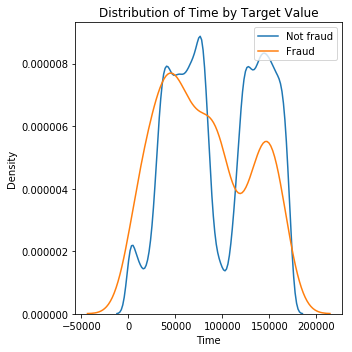

In [391]:
Distribution_plot(df,5,5,1,1,['Time'],'Kde for Time features')

At first glance, it doesn't seem to have a clear difference depending on the target, maybe the gap at 1000000...

<a id=toc4></a>
# 4. Correlation Search

### Correlation Matrix Heatmap

In [392]:
from seaborn import heatmap

In [393]:
coor_target=df.corr()["Class"].abs().sort_values(ascending=False) #We ar only keeping the correlation between feature and target
pd.DataFrame(coor_target)

,Class
Class,1.000000
V17,0.326481
V14,0.302544
V12,0.260593
V10,0.216883
V16,0.196539
V3,0.192961
V7,0.187257
V11,0.154876
V4,0.133447


Ok ! We find a lot of similarities with the EDA. The Amount feature is one of the less correlated with the target which is quite logical with the analysis before. Same thing with Time, With 0.01, it's clearly not a strong feature !

We will define a cutoff to decide which features we want to use for prediction. We'll keep features with a correlation of <strong>0.05 or higher</strong> This is a bit arbitrary (There is a gap between V2 and V6), but we could experiment afterward. 

PS: The time feature could be explore a bit more, maybe create bins of hour to find some kind of pattern

In [394]:
strong_coors=coor_target[coor_target>0.05]
strong_coors

Class    1.000000
V17      0.326481
V14      0.302544
V12      0.260593
V10      0.216883
V16      0.196539
V3       0.192961
V7       0.187257
V11      0.154876
V4       0.133447
V18      0.111485
V1       0.101347
V9       0.097733
V5       0.094974
V2       0.091289
Name: Class, dtype: float64

Figure Heatmap saved


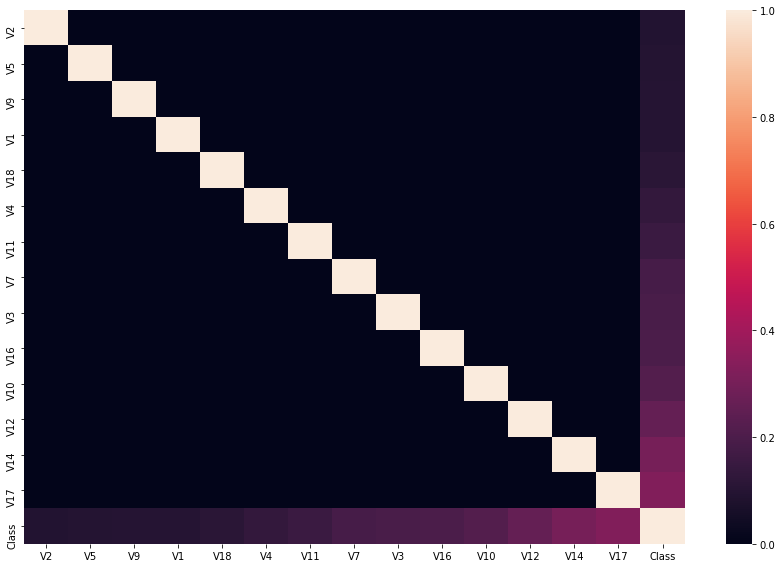

In [395]:
fig=plt.figure(figsize=(12,8))
sns.heatmap(abs(df[strong_coors.sort_values().index].corr()))
save_fig("Heatmap")
plt.show()

The heatmap reveals also that all the features are independant!

In [396]:
df=df[strong_coors.index] #Select the features kept

In [397]:
df.head()

,Class,V17,V14,V12,V10,V16,V3,V7,V11,V4,V18,V1,V9,V5,V2
0,0,-0.373610,1.539505,0.591431,-0.406331,-0.016643,-2.563411,0.335976,-0.843862,-1.389507,0.520293,-1.402087,-0.431509,0.776342,2.031091
1,0,-0.197308,0.127345,-0.857302,0.332033,1.329155,1.030211,0.207958,0.421473,-1.497385,-0.331149,-0.526362,-1.664220,0.051677,-0.212365
2,0,1.531887,0.284105,-0.954058,2.941828,-0.935486,-2.434867,0.472839,-0.773800,-0.418528,-1.311005,-2.508216,-1.005477,0.054486,1.413163
3,0,-0.535580,0.469725,0.388183,-0.126066,0.363372,1.659557,0.568485,1.380147,-0.095197,0.149435,-0.467086,-0.578858,-0.170291,0.964053
4,0,0.186527,-0.698426,-1.350500,0.591066,-0.235170,1.714426,-0.163676,-1.377991,-3.007261,0.160499,-0.629607,-1.958415,-0.776961,-0.271002


<a id=toc5></a>
# 5. Model Building

In [398]:
features = df.drop(['Class'],axis=1)
target = df['Class']

In [401]:
X_train,X_test,y_train,y_test = train_test_split(features,target, stratify=target,test_size=0.35, random_state=42)
print('Train Target \n{}\n'.format(y_train.value_counts()))
print('Test Target \n{}'.format(y_test.value_counts()))

Train Target 
0    184804
1       320
Name: Class, dtype: int64

Test Target 
0    99511
1      172
Name: Class, dtype: int64


In [402]:
lr_model = LogisticRegression()
#lr_model.fit(X_train,y_train)

In [403]:
y_pred = cross_val_predict(lr_model,X_train,y_train,cv=3)

In [404]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

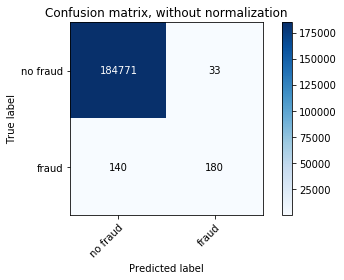

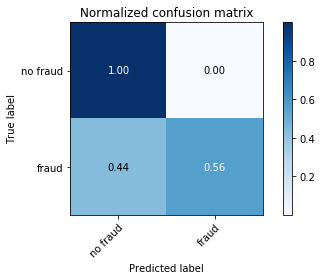

In [406]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, y_pred, classes=classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_train, y_pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [407]:
print('----------------------Classification Report----------------------')
print(classification_report(y_train,y_pred))

----------------------Classification Report----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184804
           1       0.85      0.56      0.68       320

   micro avg       1.00      1.00      1.00    185124
   macro avg       0.92      0.78      0.84    185124
weighted avg       1.00      1.00      1.00    185124



If we look at the precision and the recall, we can see that the precision at 85% is relatively good. It means that most of the samples considered fraud are indeed fraud. However, it's a tradeoff with the recall... and with unbalanced data, we see that the recall is at 56%. Which means for all the fraud presents in the dataset the algorithm found a little bit more than 50%, that's not good. We have to deal with that. 

## Let's plot a little more with recall and precision to see their behavior !

In [408]:
y_pred = cross_val_predict(lr_model,X_train,y_train,cv=3,method="decision_function") #Retrieve probabilities not just binary

In [409]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train,y_pred)

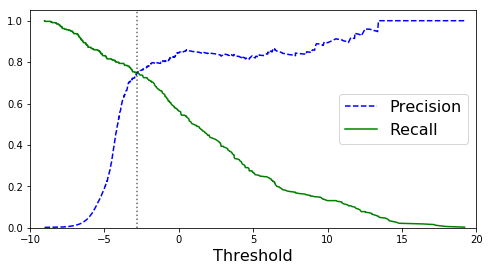

In [412]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds,xliml,xlimr):
    plt.figure(figsize=(8,4))
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold",fontsize=16)
    plt.legend(loc="center right",fontsize=16)
    plt.xlim([xliml,xlimr])
    plt.ylim([0,1.05])
plot_precision_recall_vs_threshold(precisions,recalls,thresholds,-10,20)
plt.axvline(-2.8,c="black",alpha=.6,linestyle=":")
plt.show()

In [413]:
y_pred=np.where(y_pred>=-2.8,1,0)
print('----------------------Classification Report----------------------')
print(classification_report(y_train,y_pred))

----------------------Classification Report----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184804
           1       0.75      0.75      0.75       320

   micro avg       1.00      1.00      1.00    185124
   macro avg       0.88      0.87      0.87    185124
weighted avg       1.00      1.00      1.00    185124



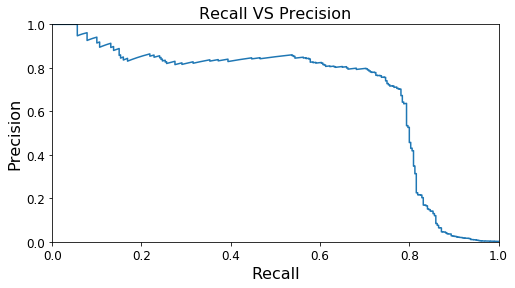

In [414]:
def plot_precision_vs_recall(precisions,recalls):
    plt.figure(figsize=(8,4))
    plt.plot(recalls,precisions)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title("Recall VS Precision",fontsize=16)
    plt.show()
plot_precision_vs_recall(precisions,recalls)

Whoa ! That's an impressive drop of the precision (with a threshold around -2.8). It makes perfect sense though. Once we found the small set of fraud if we continue to move the threshold it will find no fraud sample ! let's find a way to improve the overall score !

<a id=toc6></a>
# 6. Deal with Imbalance

<a id=toc61></a>
## &emsp; 6.1 Auto Weight

There's a quick way to deal with imbalanced target, that's class_weight. The idea is to put a penality for mislabeled sample.

In [420]:
lr_model = LogisticRegression(class_weight='balanced') #We'll use the auto balanced of scikit learn

In [421]:
y_pred = cross_val_predict(lr_model,X_train,y_train,cv=3)

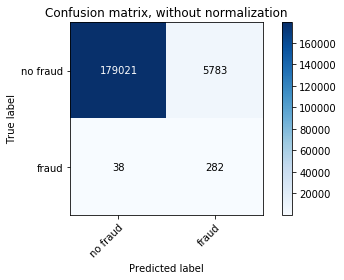

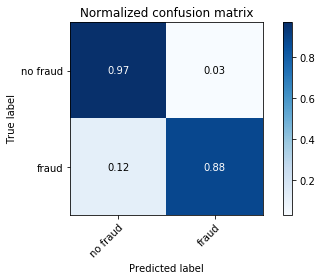

In [423]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, y_pred, classes=classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_train, y_pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [424]:
print('----------------------Classification Report----------------------')
print(classification_report(y_train,y_pred))

----------------------Classification Report----------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    184804
           1       0.05      0.88      0.09       320

   micro avg       0.97      0.97      0.97    185124
   macro avg       0.52      0.92      0.54    185124
weighted avg       1.00      0.97      0.98    185124



In [425]:
y_pred = cross_val_predict(lr_model,X_train,y_train,cv=3,method="decision_function") #Retrieve probabilities not just binary

In [426]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train,y_pred)

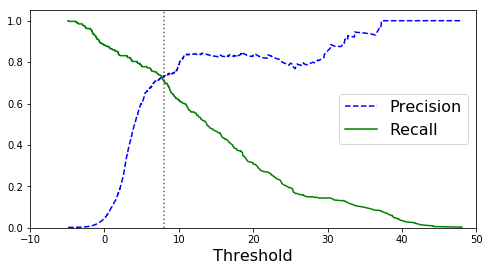

In [427]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds,-10,50)
plt.axvline(8,c="black",alpha=.6,linestyle=":")
plt.show()

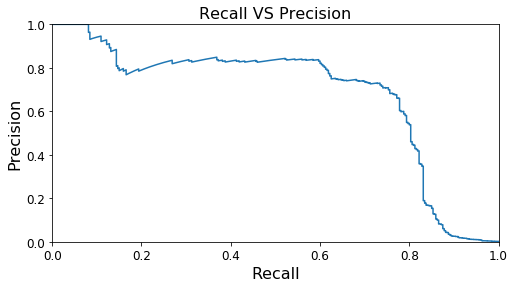

In [428]:
plot_precision_vs_recall(precisions,recalls)

Since the threshold is at 0 by default and we see that the precision and recall shift around 10, the results we see above make sense. However it doesn't seem to be the best idea to use the 'balanced' parameter since the results are worse. For further analysis we will only look at the Recall/Precision Graph and ROC to look the behavior of the different metrics depending on the threshold

<a id=toc62></a>
## &emsp; 6.2 Manual Weight

This time we will manually play with the weight parameter

Weight of 1  class
Weight of 5  class
Weight of 10  class
Weight of 50  class
Weight of 100  class
Weight of 200  class
Weight of 300  class
Weight of 400  class
Weight of 500  class
Weight of 1000  class
Figure Recall_VS_Precision_M saved


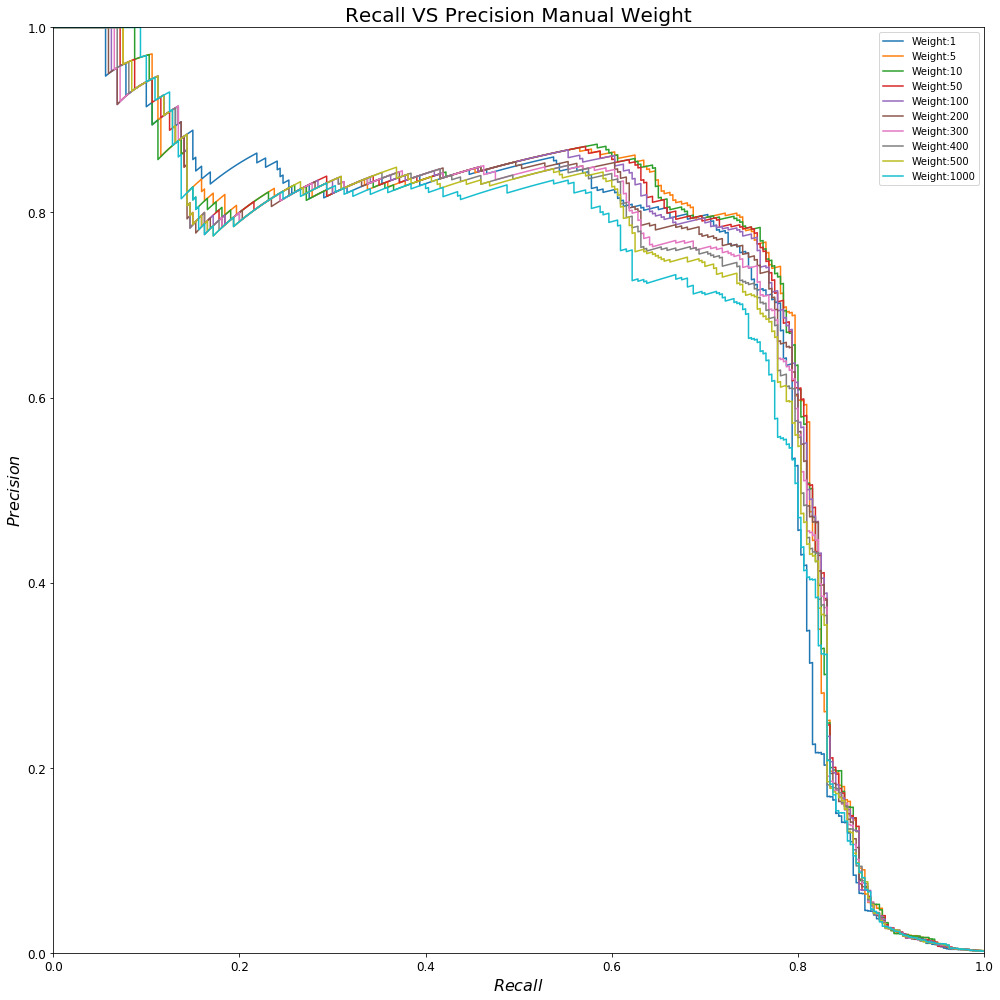

In [429]:
plt.figure(figsize=(14,14))
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$Recall$',fontsize=16)
plt.ylabel('$Precision$',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for weight in [1,5,10,50,100,200,300,400,500,1000]:
    print('Weight of {}  class'.format(weight))
    lr_model = LogisticRegression(class_weight={0:1,1:weight})
    y_pred = cross_val_predict(lr_model,X_train,y_train,cv=3,method="decision_function" )
    precisions,recalls,thresholds=precision_recall_curve(y_train,y_pred) 
    plt.plot(recalls,precisions, label='Weight:'+str(weight))

plt.title('Recall VS Precision Manual Weight',fontsize=20)
save_fig('Recall_VS_Precision_M')
plt.legend()
plt.show()    

With weight : 1 we have the first model we already analyze. We can see that a weight too important is not the best idea. The right weight seems to be 5. Indeed the orange line is always above for the best results

Another way to look into the classification is the ROC curve. The ROC curve plots the true positive rate against the false positive.

Weight of 1  class
Weight of 5  class
Weight of 10  class
Weight of 50  class
Weight of 100  class
Weight of 200  class
Weight of 300  class
Weight of 400  class
Weight of 500  class
Weight of 1000  class
Figure ROC_Curve saved


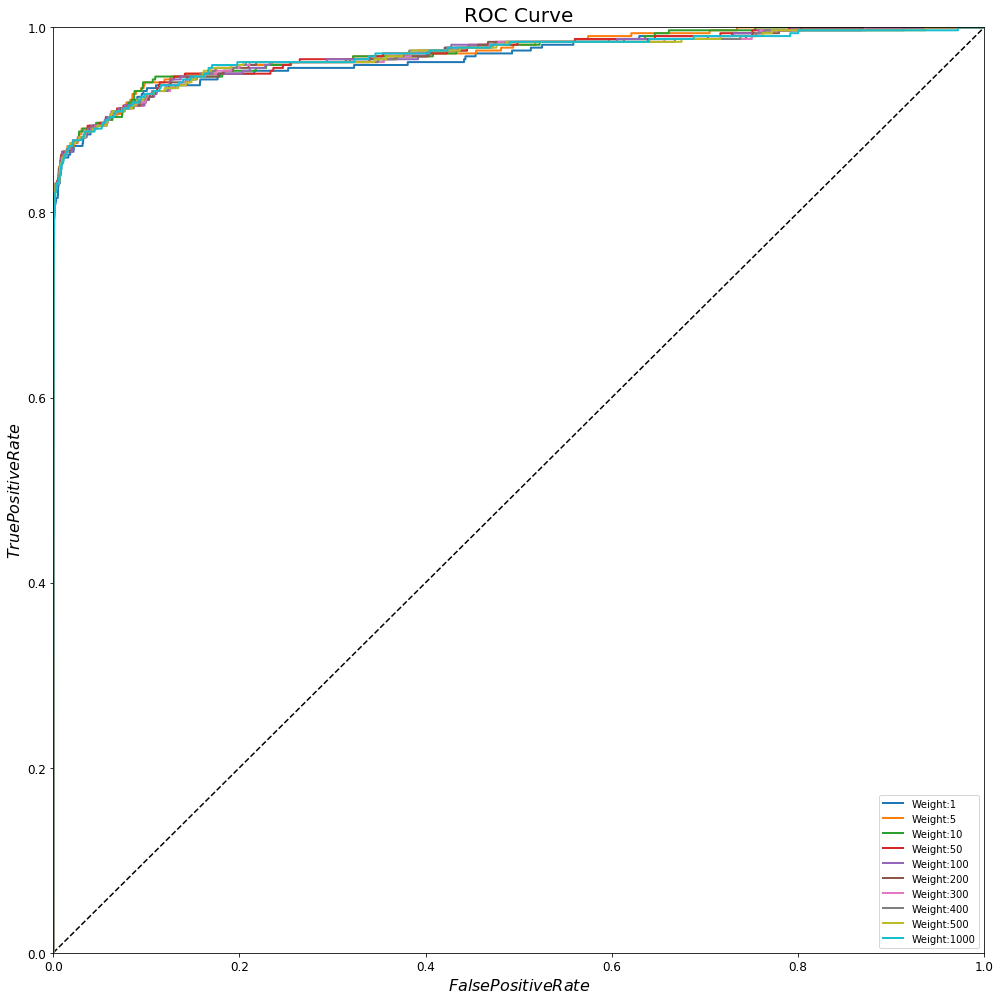

In [430]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(14,14))
plt.plot([0,1],[0,1],'k--')
plt.axis([0,1,0,1])
plt.xlabel('$False Positive Rate$',fontsize=16)
plt.ylabel('$True Positive Rate$',fontsize=16)
plt.xticks(fontsize=12)

plt.yticks(fontsize=12)
for weight in [1,5,10,50,100,200,300,400,500,1000]:
    print('Weight of {}  class'.format(weight))
    lr_model = LogisticRegression(class_weight={0:1,1:weight})
    y_pred = cross_val_predict(lr_model,X_train,y_train,cv=3,method="decision_function" )
    fpr,tpr,thresholds=roc_curve(y_train,y_pred)
    plt.plot(fpr,tpr,linewidth=2,label='Weight:'+str(weight)) 

plt.title('ROC Curve',fontsize=20)
save_fig('ROC_Curve')
plt.legend()
plt.show()    

It's more difficult to see a difference however a general rule of thumb, it's better to use the Precision/Recall Curve whenever the positive class is rare. Indeed if we look only at the ROC we could think that the model is very good but the PR curve show room for improvement

## Let's look the results with the best weight 5

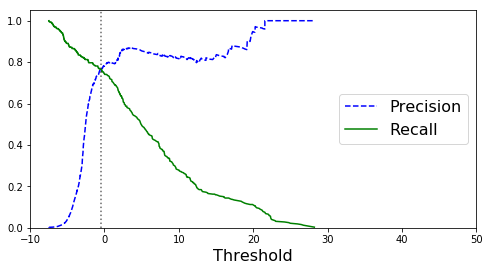

In [433]:
lr_model = LogisticRegression(class_weight={0:1,1:5})
y_pred = cross_val_predict(lr_model,X_train,y_train,cv=3,method="decision_function") #Retrieve probabilities not just binary
precisions,recalls,thresholds=precision_recall_curve(y_train,y_pred)
plot_precision_recall_vs_threshold(precisions,recalls,thresholds,-10,50)
plt.axvline(-0.5,c="black",alpha=.6,linestyle=":")
plt.show()

The best threshold seems to be at -0.5. We will to the prediction manually

In [360]:
y_pred= cross_val_predict(lr_model,X_train,y_train,cv=3,method="decision_function")

In [434]:
y_pred=np.where(y_pred>=-0.5,1,0)

In [435]:
print('----------------------Classification Report----------------------')
#y_pred = cross_val_predict(lr_model,X_train,y_train,cv=3)
print(classification_report(y_train,y_pred))

----------------------Classification Report----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184804
           1       0.77      0.77      0.77       320

   micro avg       1.00      1.00      1.00    185124
   macro avg       0.88      0.88      0.88    185124
weighted avg       1.00      1.00      1.00    185124



Precision and Recall are both at 0.77. It's Very close to the model without weight. There is a bit of improvement with the parameters of sklearn but there is a lot of way to improve this model :
- Under or Over sampling
- Play with hyperparameter with a RandomSearch (C, penalty)
- Use other algorithms like SVM or RandomClassifier

<a id=toc7></a>
# 7. Conclusion : Predict Test set

In [436]:
lr_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 5}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [447]:
y_pred=lr_model.decision_function(X_test)

In [449]:
y_pred=np.where(y_pred>=-0.5,1,0)

In [450]:
print('----------------------Classification Report----------------------')
#y_pred = cross_val_predict(lr_model,X_train,y_train,cv=3)
print(classification_report(y_test,y_pred))

----------------------Classification Report----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.79      0.85      0.82       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.89      0.92      0.91     99683
weighted avg       1.00      1.00      1.00     99683



The test set has a score similar to the train set. That is good news, that means that the model is not overfitting, but maybe a bit underfitting, that's why we listed a lot of way to improve the model.
But this is a good way to start !